In [1]:
import tensorflow as tf # type: ignore

import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load checkpoint model
from tensorflow.keras.models import load_model

# Import U-Net model
from src.models.u_net import u_net
from src.models.u_net_with_checkpointing import u_net_with_checkpointing
from src.models.smaller_u_net import smaller_u_net
from src.models.mobile_u_net import mobile_u_net
#from src.models.u_net_grad import u_net_2

# Import Dice and IoU loss
from src.evaluation.metrics import dice_coefficient, iou_coefficient

# Keras data preperation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import mixed_precision
# Keras callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

2024-07-06 12:43:16.484856: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 12:43:16.484914: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 12:43:16.487636: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 12:43:16.944275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Configuration File

In [2]:
class CFG:
    batch_size = 8
    epochs = 100
    seed = 123
    target_size = (256, 256)
    train_dir = './train/'
    valid_dir = './valid/'

# Data Extraction and Preperation

In [3]:
# Training dataset arguements
train_gen_arguments = {
    'rescale':1/255,
    'horizontal_flip':True,
    'vertical_flip':True,
    'rotation_range':45,
    'zoom_range':0.2,
    'shear_range':0.2,
    'width_shift_range':0.2,
    'height_shift_range':0.2,
    'brightness_range':[0.7, 1.3],
    'fill_mode':'reflect'
}

# Create Image Data Generators
train_data_generator = ImageDataGenerator(**train_gen_arguments)
valid_data_generator = ImageDataGenerator(rescale=1/255)

train_images_generator = train_data_generator.flow_from_directory(
    directory=CFG.train_dir + 'images',
    target_size=CFG.target_size,
    batch_size=CFG.batch_size,
    class_mode=None,
    shuffle=True,
    seed=CFG.seed
)

train_masks_generator = train_data_generator.flow_from_directory(
    directory=CFG.train_dir + 'masks',
    target_size=CFG.target_size,
    batch_size=CFG.batch_size,
    color_mode = 'grayscale',
    class_mode=None,
    shuffle=True,
    seed=CFG.seed
)

valid_images_generator = valid_data_generator.flow_from_directory(
    directory=CFG.valid_dir + 'images',
    target_size=CFG.target_size,
    batch_size=CFG.batch_size,
    class_mode=None,
    shuffle=False,
    seed=CFG.seed
)

valid_masks_generator = valid_data_generator.flow_from_directory(
    directory=CFG.valid_dir + 'masks',
    target_size=CFG.target_size,
    batch_size=CFG.batch_size,
    color_mode = 'grayscale',
    class_mode=None,
    shuffle=False,
    seed=CFG.seed
)

train_generator = zip(train_images_generator, train_masks_generator)
valid_generator = zip(valid_images_generator, valid_masks_generator)

Found 800 images belonging to 1 classes.
Found 800 images belonging to 1 classes.
Found 200 images belonging to 1 classes.
Found 200 images belonging to 1 classes.


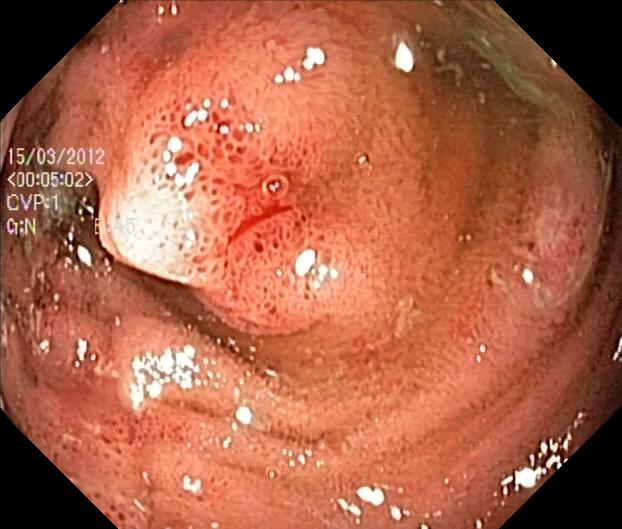

In [62]:
img = Image.open('./train/images/train/cju0qkwl35piu0993l0dewei2.jpg')
img.show()

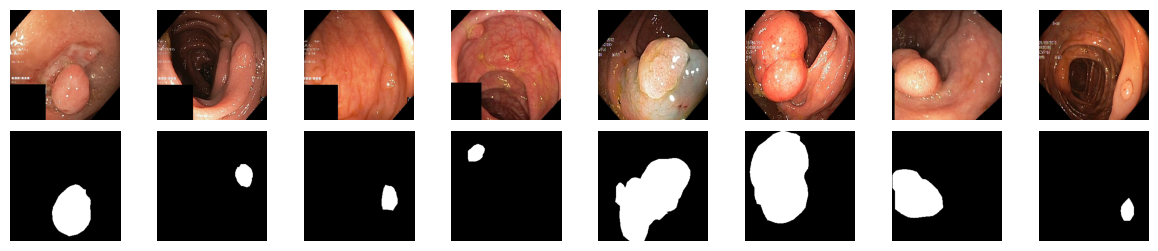

In [4]:
num_photos = min(10, CFG.batch_size)

fig, axes = plt.subplots(2, num_photos, figsize=(15, 3))

counter = 0
num_p = num_photos  # Assuming you want to stop after num_photos iterations

# Assuming valid_images_generator and valid_masks_generator are defined and yield batches of images and masks
while counter < num_p:
    # Iterate over the batches and plot the images and masks
    batch_images = next(valid_images_generator)[:CFG.batch_size]
    batch_masks = next(valid_masks_generator)[:CFG.batch_size]
    
    for i in range(CFG.batch_size):
        axes[0, i].imshow(batch_images[i], cmap='gray')
        axes[0, i].axis('off')

        axes[1, i].imshow(batch_masks[i], cmap='gray')
        axes[1, i].axis('off')
        counter += 1
        if counter == num_p:
            break

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

# Model Importing, Configurations, and Training

In [6]:
sample = train_images_generator.next()
height = sample.shape[1]
width = sample.shape[2]
channels = sample.shape[3]
input_shape = (height, width, channels)

In [8]:
model = smaller_u_net(input_shape=input_shape)

total_params = model.count_params()
print(f"\nTotal number of parameters: {total_params:,}")

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,
                                     beta_1=0.9)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coefficient, iou_coefficient])


Total number of parameters: 16,495,553


In [9]:
checkpoint_path = './model_checkpoints/smaller_u_net.h5'

if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path, custom_objects={
        'dice_coefficient': dice_coefficient,
        'iou_coefficient': iou_coefficient
    })
    print("Model loaded successfully from checkpoint.")
else:
    print(f"Error: Checkpoint file '{checkpoint_path}' not found. Model not loaded.")

# Set up keras callbacks
model_checkpoint = ModelCheckpoint(checkpoint_path,
                                   monitor='val_loss',
                                   save_best_only=True,
                                   verbose=1)

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=15,
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=10,
                              min_lr=1e-6)



Model loaded successfully from checkpoint.


In [65]:
CFG.epochs = 100

train_samples = train_images_generator.samples
valid_samples = train_images_generator.samples

steps_per_epoch = train_samples // CFG.batch_size
valid_steps = valid_samples // CFG.batch_size

In [66]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=CFG.epochs,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)


# Evaluation of Training

### Method 1

Initially I tried using the U-Net model for this problem. However, due to pc limitations I could only run a batch size of 4. This led to an unstable gradient and poor validation error. To compensate I tried increasing momentum and reducing the initial learning rate. Both methods gave no success. 
The best validation accuracy was around 84%.

### Method 2
To solve the problems from above, I tried reducing the size of the model. I reduced the depth of the U-Net by 1. This halfed the number of parameters and greatly reduced the amount of activation maps stored in memory. As a result, I could double batch size. So far this has led to a stable gradient. At the current moment we have acheived a validation accuracy of 94%. This may be able to be increased with a greater amount of training.

### Method 3
I implemented a Mobile U-Net model. This model had 6 million parameters (much less than the U Net's 30 million parameters). However, similarly to U-Net only a batch size of 4 could be used due to memory issues. Most the memory is used in the intermediate layers storing the activations for back propogatation.

### Method 4
Here I tried to get around the memory constraints by applying a range of strategies. First I tried using a float16 precision and a mixed float16 precision. This should reduce the memory by half, however this has not been successful.

### Method 5
In order to get around the memory issues, I tried implementing gradient checkpointing. There for a model of depth n, only $\sqrt n$ of the activations are stored (these are called checkpoints). When backpropogating we use the checkpoints to calculate the missing activations. This should result in 20-30% increased training time but with significant reduction in memory stored. 
In practice this has not been successful. Training speed has more than doubled and the loss does not improve and remains at an infinite value. I have the code below as I plan to re-visit this in the future.

# Trying Out Gradient Checkpointing

In [67]:
tf.keras.backend.clear_session()

#tf.keras.backend.set_floatx('float16')

#mixed_precision.set_global_policy('mixed_float16')

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [69]:
model = u_net(input_shape=input_shape)
recompute_grad_model = tf.recompute_grad(model)

In [71]:
# Define loss function and optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(1e-5)

In [72]:
# Training step function
@tf.function
def train_step(images, masks):
    with tf.GradientTape() as tape:
        predictions = recompute_grad_model(images, training=True)
        loss = loss_fn(masks, predictions)
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss

# Training loop
def train(epochs):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for step in range(steps_per_epoch):
            images, masks = next(train_generator)
            loss = train_step(images, masks)
            if (step+1) % 20 == 0:
                print(f"Step {step+1}, Loss: {loss.numpy():.4f}")


In [78]:
train(epochs=5)

Epoch 1/5
Step 20, Loss: nan
Step 40, Loss: nan
Step 60, Loss: nan
Step 80, Loss: nan
Step 100, Loss: nan
Epoch 2/5
Step 20, Loss: nan
Step 40, Loss: nan
Step 60, Loss: nan
Step 80, Loss: nan
Step 100, Loss: nan
Epoch 3/5
Step 20, Loss: nan
Step 40, Loss: nan
Step 60, Loss: nan
Step 80, Loss: nan
Step 100, Loss: nan
Epoch 4/5
Step 20, Loss: nan
Step 40, Loss: nan
Step 60, Loss: nan
Step 80, Loss: nan
Step 100, Loss: nan
Epoch 5/5
Step 20, Loss: nan
Step 40, Loss: nan
Step 60, Loss: nan
Step 80, Loss: nan
Step 100, Loss: nan


In [77]:
tf.config.experimental_run_functions_eagerly(True)